In [232]:
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import ale_py
import random
import glob
import imageio
import cv2 as cv
import os
import time
from collections import deque

In [233]:
env = gym.make("ALE/Pong-v5")

In [234]:
action_map = {
    0 : 0, # NOOP
    1 : 2, # RIGHT
    2 : 3 # LEFT
}

In [235]:
# # --- Pygame init ---
# pygame.init()
# screen = pygame.display.set_mode((400, 300))
# pygame.display.set_caption("Play Pong with Keyboard")
# clock = pygame.time.Clock()

# # --- Gym init ---
# env = gym.make("ALE/Pong-v5", render_mode="human")
# obs, info = env.reset()

# # Mapping: keys -> actions
# # 0: NOOP, 1: FIRE, 2: RIGHT, 3: LEFT, 4: RIGHTFIRE, 5: LEFTFIRE
# key_action_map = {
#     pygame.K_UP: 2,     # Move up (RIGHT in Pong's terms)
#     pygame.K_DOWN: 3,   # Move down (LEFT in Pong's terms)
#     pygame.K_SPACE: 1,  # Fire (start the game)
# }

# done = False
# while True:
#     action = 0  # Default NOOP

#     # --- Handle events ---
#     for event in pygame.event.get():
#         if event.type == pygame.QUIT:
#             env.close()
#             pygame.quit()
#             raise SystemExit
        
#         if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
#             env.close()
#             pygame.quit()
#             raise SystemExit

#     # Get pressed keys
#     keys = pygame.key.get_pressed()
#     for key, mapped_action in key_action_map.items():
#         if keys[key]:
#             action = mapped_action

#     # Step the environment
#     obs, reward, terminated, truncated, info = env.step(action)
#     done = terminated or truncated

#     if done:
#         obs, info = env.reset()

#     clock.tick(60)  # Limit loop to 60 FPS

In [236]:
from importlib import reload
import utils
import dqn

# Force reload
reload(utils)
reload(dqn)

<module 'dqn' from 'c:\\Users\\lucas\\Documents\\Coursera\\RL Specialization\\RL_applications\\Pong\\dqn.py'>

In [237]:
# from utils import generate_evaluation_states
# ev_states = generate_evaluation_states(env, device, 100)
# torch.save(ev_states, "ev_states.pt")

# 1. DQN

## 1. Training

In [238]:
# Resume training of start from scratch
resume_training = False
checkpoint = "training/dqn/v1/training2/1950.pth"

max_training_time = 7 #h

In [239]:
training_numbers = [int(folder.split("training")[-1]) for folder in glob.glob("training/dqn/v1/*")]
training_number = max(training_numbers) + 1 if len(training_numbers) > 0 else 1
os.mkdir(f"training/dqn/v1/training{training_number}")

In [240]:
from dqn import QNetwork, ReplayBuffer, Update_Q

device = 'cpu'

Q = QNetwork(input_dim = 10, output_dim = 3).to(device)
Q_target = QNetwork(input_dim = 10, output_dim = 3).to(device)
Q_target.load_state_dict(Q.state_dict())
Q_optimizer = torch.optim.Adam(Q.parameters(), lr = 0.0001)
Buffer   = ReplayBuffer()

ev_states = torch.load("ev_states.pt")

# Hyperparameters
gamma = 0.99
epsilon = 1
epsilon_min = 0.1
epsilon_decay = 0.000005
batch_size = 32
max_episode = 10
max_time_steps = 10000
update_frequency = 1
target_update_frequency = 2000
checkpoint_frequency = 5
ever_won = False

In [241]:
from dqn import load_checkpoint

if resume_training:
    training_vars = load_checkpoint(Q, Q_optimizer, Buffer, checkpoint)
    Q_target.load_state_dict(Q.state_dict())
    returns, avg_Qvalues, td_losses, episode_start, epsilon = training_vars
else:
    episode_start = 0
    returns = []
    avg_Qvalues = []
    td_losses = []

In [242]:
from utils import get_state, generate_video
from dqn import save_checkpoint, get_avg_Qvalues

start_time = time.time()
tot_training_steps = 0
ball_position = (0, np.array([0, 0]))

for episode in range(episode_start, max_episode):

    total_reward = 0
    points_scored = 0

    # Skip first frame (different color)
    frame, _ = env.reset()
    _ = env.step(0)

    frame, reward, terminated, truncated, info = env.step(0)
    ball_position, player_position, state = get_state(frame, ball_position)
    state = torch.tensor(state).float().to(device)

    for t in range(max_time_steps):

        with torch.no_grad():
            # Decaying epsilon
            epsilon = max(epsilon_min, epsilon - epsilon_decay)
            # epsilon-greedy action selection
            if random.random() < epsilon:
                action = np.random.choice(list(action_map.keys()))
            else:
                action = torch.argmax(Q(state)).item()

        frame, reward, terminated, truncated, info = env.step(action_map[action])

        ball_position, player_position, next_state = get_state(frame, ball_position, player_position)
        next_state = torch.tensor(next_state).float().to(device)

        total_reward += reward
        if reward == 1 : points_scored += 1

        Buffer.put([state, int(action), reward, next_state, terminated, truncated])

        if Buffer.size() > 1000 and t % update_frequency == 0:
                td_loss = Update_Q(Buffer, Q, Q_target, Q_optimizer, batch_size, gamma)
                td_losses.append(td_loss)

        tot_training_steps += 1
        if tot_training_steps % target_update_frequency == 0:
            Q_target.load_state_dict(Q.state_dict())

        if terminated or truncated:
                break

        state = next_state

    # print('episode: {}, reward: {:.1f}'.format(episode, total_reward))
    returns.append(total_reward)
    avg_Qvalues.append(get_avg_Qvalues(Q, ev_states))

    if (episode + 1) % 30 == 0:
        print(f"{episode+1} episodes done. Average reward on last 30 ep. : {np.mean(returns[-30:])}")

    if points_scored == 21 and not ever_won:
        ever_won = True
        print(f"First win ! (Episode {episode})")

    # Training checkpoint
    if (episode + 1) % checkpoint_frequency == 0:
        save_checkpoint(Q, Q_optimizer, Buffer, returns, avg_Qvalues, td_losses, episode, epsilon, f"training/dqn/training{training_number}/{episode+1}.pth")
        generate_video(env, Q, device, action_map, epsilon=0, n_episodes=1, filename=f"training/dqn/training{training_number}/{episode+1}.mp4")

    if time.time() - start_time > 3600 * max_training_time:
        print(f"Maximum training time of {max_training_time}h exceeded. Interrupting training after {episode} episodes.")
        break

env.close()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x9 and 10x256)

Text(0, 0.5, 'Average Return')

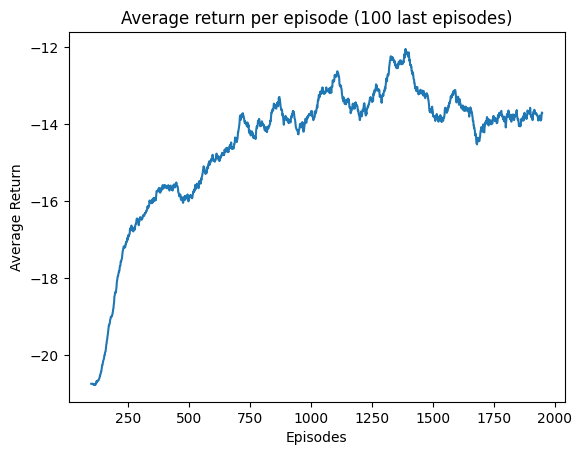

In [ ]:
avg_returns = [np.mean(returns[i-100:i]) for i in range(100, len(returns))]
plt.plot(range(100, len(returns)), avg_returns)
plt.title("Average return per episode (100 last episodes)")
plt.xlabel("Episodes")
plt.ylabel("Average Return")

Text(0, 0.5, 'Average Q_value')

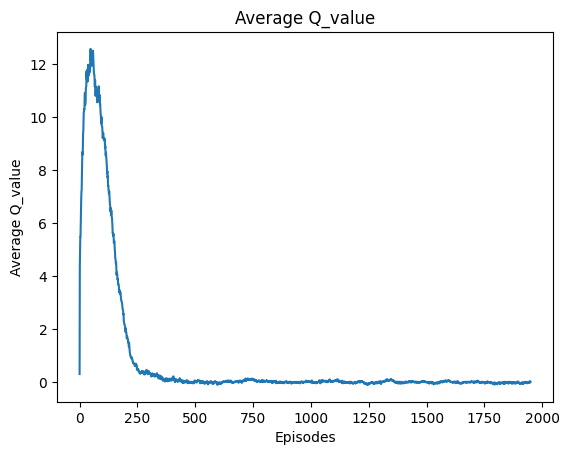

In [ ]:
plt.plot(range(len(avg_Qvalues)), avg_Qvalues)
plt.title("Average Q_value")
plt.xlabel("Episodes")
plt.ylabel("Average Q_value")

Text(0, 0.5, 'TD Loss')

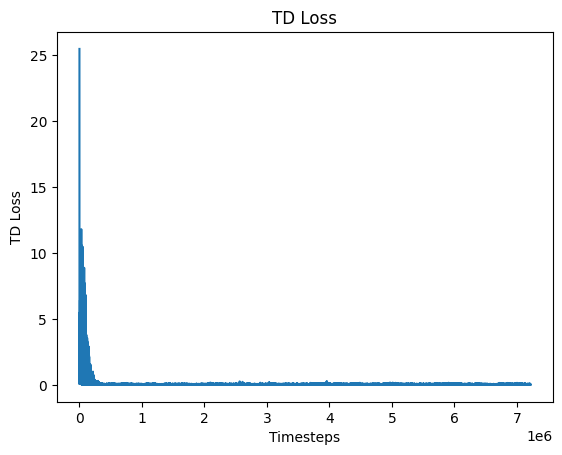

In [ ]:
plt.plot(range(len(td_losses)), td_losses)
plt.title("TD Loss")
plt.xlabel("Timesteps")
plt.ylabel("TD Loss")

## 2. Evaluation

In [ ]:
from dqn import evaluate_average_return

av_return, victory_rate = evaluate_average_return(Q, env, device, 50, action_map)
print("Results of evaluation on 50 episodes :")
print(f"Average return : {av_return:.2f}")
print(f"Victory rate : {victory_rate:.2f}")

# Benchmark

In [ ]:
assert 1 == 0 # Do not execute Benchmark

In [ ]:
frame, _ = env.reset()
_ = env.step(0)
ball_position = (0, np.array([0, 0]))

In [ ]:
from utils import get_state

for i in range(1):
    frame, reward, terminated, truncated, info = env.step(0)
    ball_position, state = get_state(frame, ball_position)
    state = torch.tensor(state).float().to(device)

tensor([ 1.0000,  1.0000,  1.0000, 60.5000, 21.5000, -8.0000, -4.0000, 76.5000,
         9.5000])
tensor([1.1390, 1.1349, 1.1348], grad_fn=<ViewBackward0>) 0


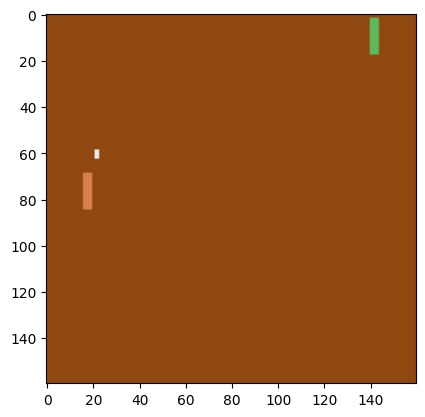

In [ ]:
plt.imshow(frame[34:194])
print(state)
print(Q(state), action_map[torch.argmax(Q(state)).item()])